<a href="https://colab.research.google.com/github/kannavdhawan/Multilayer_perceptron_CNN_cifar10/blob/master/657_assignment_3_q_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np 

import timeit
import random 

import pickle
from matplotlib import pyplot as plt

import keras
from keras.datasets import cifar10
from keras import preprocessing
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD, Adam
from keras import regularizers

## Loading and Preprocessing dataset.

In [17]:
class Data_gen:
    """
        Data_gen class loads the CIFAR10 dataset and performs preprocessing.
    
    """
    
    def __init__(self):
        """
        Method for initializing a Data_gen object.
        """
        pass

    def load_dataset(self,dataset_name):
        """
        Loads the cifar10 dataset from keras api.
        
        Args: 
            dataset_name(obj)
        
        Attributes:
            dataset_name(obj): Name of the data set (cifar10)
            
        Returns: 
            Loaded dataset:
            X_train
            Y_train
            X_test
            Y_test
        """
        
        self.dataset_name=dataset_name
        
        (X_train,Y_train),(X_test,Y_test)=self.dataset_name.load_data()       # Loading data from keras: cifar10 
        

        # Dataset exploration
        
        print("X_train: ",X_train.shape)    
        print("Y_train: ",Y_train.shape)
        print("X_test: ",X_test.shape)
        print("Y_test: ",Y_test.shape)

        print("Distinct labels:", np.unique(Y_train))

        
        #Showing the images. 
        
        for i in range(9):
            plt.subplot(330 + 1 + i)
            plt.imshow(X_train[i])
        plt.show()

        return X_train,Y_train,X_test,Y_test
    
    def preprocess(self,splits,sample_train,sample_percentage):
        """
            Performs the preprocessing steps for the dataset. Splits the dataset into 20% (10000) values out of (50000) for training.
            
            Args:
                
                splits (Tuple)
                sample_train (Bool)
                sample_percentage (Float)
            
            Atributes:
            
                splits (Tuple): A tuple of data(numpy arrays) returned by method "load_dataset"
                sample_train (Bool): A boolean to sample the (50000) training data X_train into (10000) X_train. {Preset to True}.
                sample_percentage (Float): preset percentage of 20% as per the task.
                
            Returns: 
                 X_train_normalized (numpy array): Shape => (10000,32,32,3) , Preprocessed 10000 randomly sampled samples for training
                 Y_train (numpy array): Shape => (10000,), 10000 randomly sampled categorical labels for training.
                 X_test_normalized (numpy array): Shape => (10000,32,32,3), Preprocessed test set.
                 Y_test (numpy array): Shape => (10000,) 10000 randomly sampled categorical labels for training.
        
        """
        self.splits=splits
        self.sample_train=sample_train
        self.sample_percentage=sample_percentage
        
        X_train,Y_train,X_test,Y_test=self.splits           #unpacking tuple

        # Preprocessing
        
        Y_train=to_categorical(Y_train)                     #50000  Converting into categorical values/one hot encoded
        Y_test=to_categorical(Y_test)                       #10000

       

        X_train_normalized=X_train.astype('float32')        # converting unsigned into float
        X_test_normalized=X_test.astype('float32')
        X_train_normalized=X_train_normalized/255.0         #50000 . Normalizing the data to be in between 0 and 1 by diving with the max value.
        X_test_normalized=X_test_normalized/255.0           #10000

        
        if self.sample_train:                               # sampling for required percentage of data for training..
            
            sample_size=int((self.sample_percentage)*(len(X_train_normalized)))    # creates a sample size.
            
            idx=np.random.choice(np.arange(len(X_train_normalized)),
                                 sample_size,replace=False) # generates a 1-D numpy array with randomized indexes.
    #         print(len(set(idx.tolist())))

            X_train_normalized=X_train_normalized[idx]      #10000 Fetching 20% randomized data as per indexing done.
            Y_train=Y_train[idx]                            #10000 Fetching the same indexed target labels.
        # creating validation set out of test set..
        
        real_test_indexes=np.arange(len(X_test_normalized))
        idx_val=set(np.random.choice(real_test_indexes,int(len(X_test_normalized)/2),replace=False).tolist())
        idx_test=set(real_test_indexes.tolist())-idx_val
        
        print("set intersection")
        print(idx_val.intersection(idx_test))
        print(np.asarray(list(idx_val)).shape)
        X_val_normalized=X_test_normalized[np.asarray(list(idx_val))]
        Y_val=Y_test[np.asarray(list(idx_val))]
        
        X_test_normalized=X_test_normalized[np.asarray(list(idx_test))]
        Y_test=Y_test[np.asarray(list(idx_test))]
        
        return X_train_normalized,Y_train,X_test_normalized,Y_test,X_val_normalized,Y_val

## Creating 3 Models:
- MLP
- CNN-1
- CNN-2 

In [18]:
class Models:
    """
    This class contains 3 Architectures.
    MLP: Multilayer perceptron Architecture with conditional statements to modify the architecture.
    CNN-1: Architecture with No Dropouts. 
    CNN-2: Architecture with Dropouts.    
    """
    def __init__(self,X_train_normalized):
        """Method for initializing MOdels object.
        
        Args:
            X_train_normalized (numpy array)
            
        Atributes:
            X_train_normalized (numpy array): Train set to feed the input shape for the Architectures
        """
        
        self.X_train_normalized=X_train_normalized
    
    def MLP(self,neurons,add_d3,add_d4): 
        
        """ Multi layer perceptron with 2 Dense/Hidden Layers and 1 output layer. Neurons: 512, Activation: sigmoid in H.L. Softmax at output
            layer with 10 neurons.
            
            Args:
                neurons (int)
                add_d3 (Bool)
                add_d4 (Bool)
            
            
            Attributes:
                neurons (int): Number of neurons in the dense layer.
                add_d3 (Bool): Boolean to add an additional(3rd) dense layer.
                add_d4 (Bool): Boolean to add an additional(4th) dense layer.
                
            Returns:
                model: Compiled model with the given architecture.
        
        """
        self.neurons=neurons
        self.add_d3=add_d3
        self.add_d4=add_d4
        
        model = Sequential()             # Sequential keras Model
        
        model.add(Flatten())             # Flattening the imput layer to pass through the dense layer.=> (None, 32,32,3)=> (3072)
        
        model.add(Dense(self.neurons))   # A Fully connected dense layer. Takes neurons as 512 in our case. Params: 1573376
        model.add(Activation('sigmoid')) # sigmoid as activation function. maps values between 0 and 1. 
      
        model.add(Dense(self.neurons))   # Another Fully connected layer
        model.add(Activation('sigmoid')) # Sigmoid as Activation function.
        
        if self.add_d3:                  # To modify the architecture, and add an another dense layer. (3rd)
            
            model.add(Dense(self.neurons))
            model.add(Activation('sigmoid'))
        
        if self.add_d3:                  # To modify the architecture, and add an another dense layer. (4th)
            
            model.add(Dense(self.neurons))
            model.add(Activation('sigmoid'))
        
        model.add(Dense(10))             # Fully connected layer with 10 classes as output layer.
        model.add(Activation('softmax')) # Softmax function to convert arbitary resulted real values into probabilities.

        model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) # Initializes the optimizer and loss function for training.
        
        return model
    
    def CNN1(self,neurons): 
        
        """ Convolutional Neural Network with 2 Con2D Layers, 2 Dense Layers and 1 output layer. 
            Neurons: 512, Activation: sigmoid in H.L. Softmax at output layer with 10 neurons.
            
            Args:
            
                neurons (int)
            
            Attributes:
            
                neurons (int): Number of neurons in the dense layer.
            
            Returns:
                model: Compiled CNN model with the given architecture.
        """
        self.neurons=neurons
        
        model= Sequential() # Seq model keras.
        
        model.add(Conv2D(64, (3,3), padding='same', input_shape=     # Conv layer with 64 filters, filter shape=(3,3,3), input shape => (B.S,32,32,3) 
                         self.X_train_normalized.shape[1:])) 
        model.add(Activation('relu'))                                # Relu as activation.
        
        model.add(Conv2D(64,(3, 3),padding='same'))                                 # Con layer with 64 filters, filter shape=(3,3,64), input shape=> (B.s,32,32,64)
        model.add(Activation('relu'))
        
        model.add(Flatten())   # Flattening the input before dense layer.
        
        model.add(Dense(self.neurons))                               # Dense/Fully connected layer with 512 neurons
        model.add(Activation('sigmoid'))                             # SGD as activation function.
        
        model.add(Dense(self.neurons))                               # 2nd Dense layer with same number of neurons i.e. 512.        
        model.add(Activation('sigmoid'))                             # SGD maps the result b/1 0 and 1.
        
        model.add(Dense(10))                                         # Output layer with 10 neurons for 10 classes 
        
        model.add(Activation('softmax'))                             # softmax to output the probs.

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Initializes the optimizer and loss function for training.
        return model
    
    def CNN2(self,neurons):
        
        """ Convolutional Neural Network with 2 Con2D Layers, 2 Dense Layers, 2 MaxPool2D, 2 Dropouts and 1 output layer. 
            Neurons: 512, Activation: sigmoid in H.L. Softmax at output layer with 10 neurons.
            
            Args:
            
                neurons (int)
            
            Attributes:
            
                neurons (int): Number of neurons in the dense layer.
            
            Returns:
                model: Compiled CNN model with the given architecture.
        """
        
        self.neurons=neurons
        
        model=Sequential()
        
        model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same',activation='relu',
                         input_shape=self.X_train_normalized.shape[1:]))                    # Conv layer with 64 filters, filter shape=(3,3,3), input shape => (B.S,32,32,3) 
        model.add(MaxPooling2D(pool_size=(2,2)))                                            # Max pooling with a filter of (2,2) for capturing important features.

        model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu'))  # Conv layer with 64 filters, filter shape=(3,3,64), input shape => (B.S,32,32,3)         
        model.add(MaxPooling2D(pool_size=(2,2)))                   # Max pooling with a filter of (2,2) for capturing important features.
        
        model.add(Flatten())                                       # Flattening before the dense layer
        model.add(Dense(self.neurons,activation='sigmoid'))        # Fully connected layer with 512 neurons and sigmoid as activation.
        model.add(Dropout(0.2))                                    # Dropout of 0.2 to prevent overfitting.

        model.add(Dense(self.neurons,activation='sigmoid'))
        model.add(Dropout(0.2))                                    # Dropout of 0.2 to prevent overfitting after 2nd dense layer.
        
        model.add(Dense(10, activation='softmax'))                 # Dense layer with 10 neurons as output layer.
        
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # Initializes the optimizer and loss function for training.
        return model 

## Creating basic plots for 3 Networks

- Training Accuracy vs Validation accuracy
- Training Loss vs Validation Loss

In [19]:
class Plots:
    """Plots for training and testing process: loss and accuracy
    """ 
    def __init__(self,model):
        """
        Args:
            model (obj)
            
        Attributes: 
            model (obj): Trained model to get the accuracy and loss for training and validation for plots using history object.
            
        """
        self.model=model
        
    def accuracy(self):
        """
        plots the Training Accuracy vs Validation Accuracy
        """
        
        self.accuracy=self.model.history['accuracy']          #Get traning accuracy from model.history
        self.val_accuracy=self.model.history['val_accuracy']  #Get val accuracy from model.history
        
        plt.figure(figsize=(8,7))

        plt.plot(self.accuracy,'b')
        plt.plot(self.val_accuracy,'g')
        plt.xticks(np.arange(1,6,1))
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Accuracy','Validation Accuracy'])
        plt.show()
#         plt.savefig("acc.png")
    
    def loss(self):
        """
        plots the Training Loss vs Validation Loss
        """
        self.loss=self.model.history['loss']                    #Get traning loss from model.history
        self.val_loss=self.model.history['val_loss']            #Get val loss from model.history
        
        plt.figure(figsize=(8,7))

        plt.plot(self.loss,'b')
        plt.plot(self.val_loss,'g')
        plt.xticks(np.arange(1,6,1))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss','Validation Loss'])
        plt.show()
#         plt.savefig("loss.png")

X_train:  (50000, 32, 32, 3)
Y_train:  (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)
Distinct labels: [0 1 2 3 4 5 6 7 8 9]


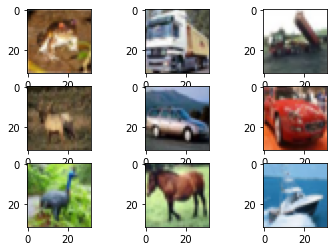

set intersection
set()
(5000,)


In [20]:
# if __name__=='__main__':
    
#Creating instance of Data_gen and calling methods of Data_gen class.
cf=Data_gen()
splits=cf.load_dataset(cifar10)
data=cf.preprocess(splits,sample_train=True,sample_percentage=0.2)
X_train_normalized,Y_train,X_test_normalized,Y_test,X_val_normalized,Y_val=data

In [21]:
print(X_train_normalized.shape)
print(X_test_normalized.shape)
print(X_val_normalized.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(10000, 32, 32, 3)
(5000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 10)
(5000, 10)
(5000, 10)


----------------------------------
# MLP
---------------------------------

In [22]:
#Creating instance of Models for MLP

mlp_ob=Models(X_train_normalized)

"""
MLP-------------------------------
"""

start_mlp=timeit.default_timer()
print("MLP(512,add_d3=False,add_d4=False)")

"""
Call base MLP: Neurons 512 | Layers 2 Dense
"""
mlp_base=mlp_ob.MLP(512,add_d3=False,add_d4=False) 
mlp_base_h=mlp_base.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

stop_mlp=timeit.default_timer()



print("MLP(1024,add_d3=False,add_d4=False)")
"""
Call MLP: Neurons 1024 | Layers 2 Dense
"""

mlp1=mlp_ob.MLP(1024,add_d3=False,add_d4=False) 
mlp1_h=mlp1.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))


print("MLP(2048,add_d3=False,add_d4=False)")
"""
Call MLP: Neurons 2048 | Layers 2 Dense
"""

mlp2=mlp_ob.MLP(2048,add_d3=False,add_d4=False) 
mlp2_h=mlp2.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(512,add_d3=True,add_d4=False)")

"""
Call base MLP: Neurons 512 | Layers 3 Dense
"""
mlp3=mlp_ob.MLP(512,add_d3=True,add_d4=False) 
mlp3_h=mlp3.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(1024,add_d3=True,add_d4=False)")

"""
Call MLP: Neurons 1024 | Layers 3 Dense
"""

mlp4=mlp_ob.MLP(1024,add_d3=True,add_d4=False) 
mlp4_h=mlp4.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(2048,add_d3=True,add_d4=False)")
"""
Call MLP: Neurons 2048 | Layers 3 Dense
"""

mlp5=mlp_ob.MLP(2048,add_d3=True,add_d4=False) 
mlp5_h=mlp5.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))


print("MLP(512,add_d3=True,add_d4=True)")

"""
Call base MLP: Neurons 512 | Layers 4 Dense
"""
mlp6=mlp_ob.MLP(512,add_d3=True,add_d4=True) 
mlp6_h=mlp6.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(1024,add_d3=True,add_d4=True)")

"""
Call MLP: Neurons 1024 | Layers 4 Dense
"""

mlp7=mlp_ob.MLP(1024,add_d3=True,add_d4=True) 
mlp7_h=mlp7.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(2048,add_d3=True,add_d4=True)")
"""
Call MLP: Neurons 2048 | Layers 4 Dense
"""

mlp8=mlp_ob.MLP(2048,add_d3=True,add_d4=True) 
mlp8_h=mlp8.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))


MLP(512,add_d3=False,add_d4=False)
Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 2s 186us/step - loss: 2.0625 - accuracy: 0.2386 - val_loss: 1.9222 - val_accuracy: 0.3250
Epoch 2/5
10000/10000 [==============================] - 2s 171us/step - loss: 1.8894 - accuracy: 0.3120 - val_loss: 1.8658 - val_accuracy: 0.3208
Epoch 3/5
10000/10000 [==============================] - 2s 170us/step - loss: 1.8248 - accuracy: 0.3419 - val_loss: 1.8608 - val_accuracy: 0.3186
Epoch 4/5
10000/10000 [==============================] - 2s 169us/step - loss: 1.7949 - accuracy: 0.3410 - val_loss: 1.7810 - val_accuracy: 0.3612
Epoch 5/5
10000/10000 [==============================] - 2s 172us/step - loss: 1.7337 - accuracy: 0.3721 - val_loss: 1.7751 - val_accuracy: 0.3594
MLP(1024,add_d3=False,add_d4=False)
Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 2s 219us/step - loss: 2.1503 - accuracy

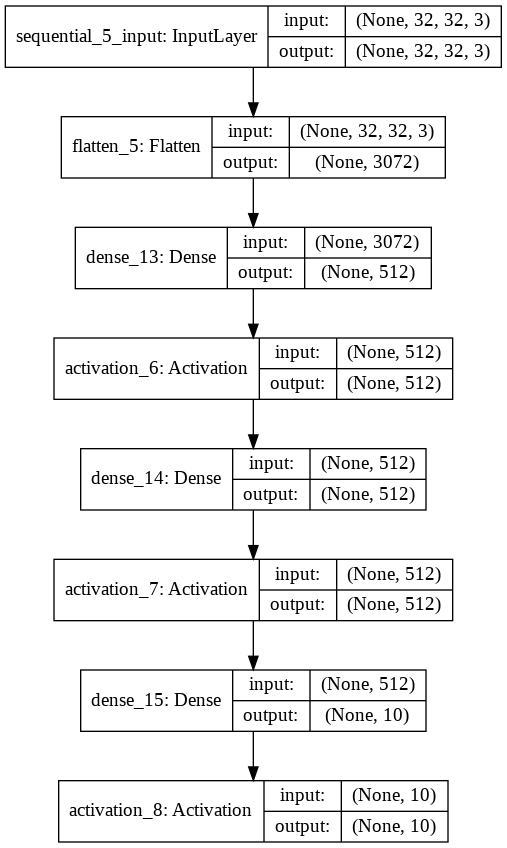

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(mlp_base, to_file='mlp_base.png', show_shapes=True, show_layer_names=True)

------------------------------------------
## CNN-1
------------------------------------------

In [24]:
print("CNN-1")

# creating an instance of Models class for CNN-1

cnn1_ob=Models(X_train_normalized)
"""
CNN-1 ---------------------------------------
"""
start_cnn1=timeit.default_timer()

cnn1=cnn1_ob.CNN1(512)
cnn1_h=cnn1.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

stop_cnn1=timeit.default_timer()

CNN-1
Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 9s 939us/step - loss: 1.7661 - accuracy: 0.3427 - val_loss: 1.4941 - val_accuracy: 0.4464
Epoch 2/5
10000/10000 [==============================] - 9s 919us/step - loss: 1.3573 - accuracy: 0.5044 - val_loss: 1.3496 - val_accuracy: 0.5154
Epoch 3/5
10000/10000 [==============================] - 9s 920us/step - loss: 1.0423 - accuracy: 0.6264 - val_loss: 1.3319 - val_accuracy: 0.5320
Epoch 4/5
10000/10000 [==============================] - 9s 924us/step - loss: 0.6566 - accuracy: 0.7745 - val_loss: 1.3973 - val_accuracy: 0.5502
Epoch 5/5
10000/10000 [==============================] - 9s 919us/step - loss: 0.2810 - accuracy: 0.9173 - val_loss: 1.6407 - val_accuracy: 0.5336


In [25]:
cnn1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_45 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_46 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_52 (Dense)             (None, 512)               33554944  
_________________________________________________________________
activation_47 (Activation)   (None, 512)             

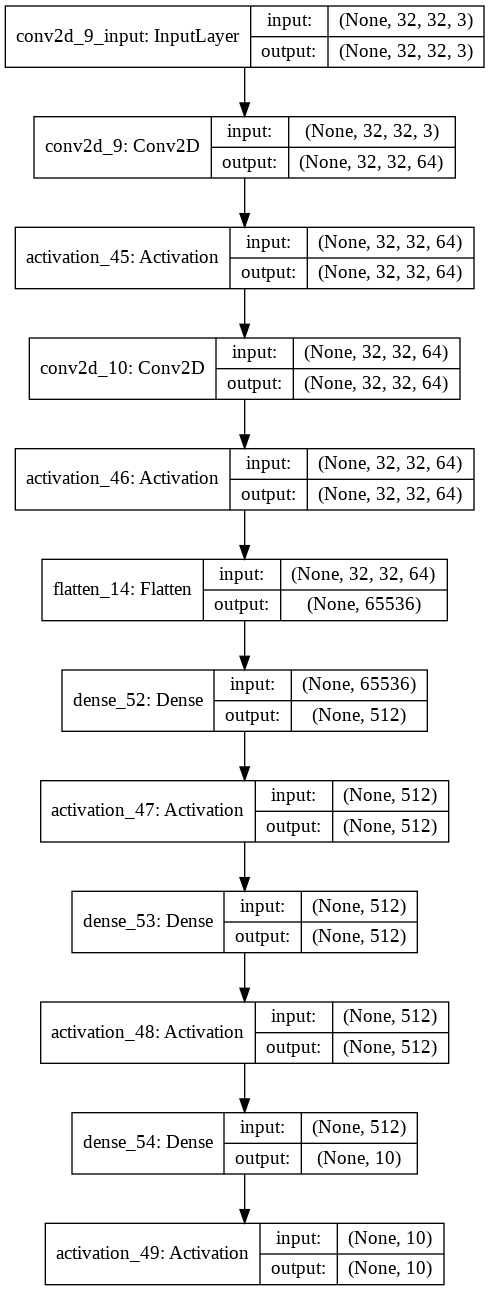

In [26]:
plot_model(cnn1, to_file='cnn1.png', show_shapes=True, show_layer_names=True)

---------------------------------------------
## CNN-2
---------------------------------------------

In [27]:
# creating an instance of Models for CNN-2

print("CNN-2")

cnn2_ob=Models(X_train_normalized)

"""
CNN-2
"""
start_cnn2=timeit.default_timer()

cnn2=cnn2_ob.CNN2(512)
cnn2_h=cnn2.fit(X_train_normalized,Y_train,batch_size=32,epochs=5,validation_data=(X_val_normalized,Y_val))

stop_cnn2=timeit.default_timer()

CNN-2
Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 3s 270us/step - loss: 1.9413 - accuracy: 0.2741 - val_loss: 1.6421 - val_accuracy: 0.3926
Epoch 2/5
10000/10000 [==============================] - 2s 248us/step - loss: 1.5312 - accuracy: 0.4394 - val_loss: 1.4323 - val_accuracy: 0.4898
Epoch 3/5
10000/10000 [==============================] - 2s 246us/step - loss: 1.3470 - accuracy: 0.5094 - val_loss: 1.3726 - val_accuracy: 0.5130
Epoch 4/5
10000/10000 [==============================] - 2s 248us/step - loss: 1.2011 - accuracy: 0.5700 - val_loss: 1.2125 - val_accuracy: 0.5676
Epoch 5/5
10000/10000 [==============================] - 2s 248us/step - loss: 1.0838 - accuracy: 0.6069 - val_loss: 1.2355 - val_accuracy: 0.5566


In [28]:
cnn2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)             

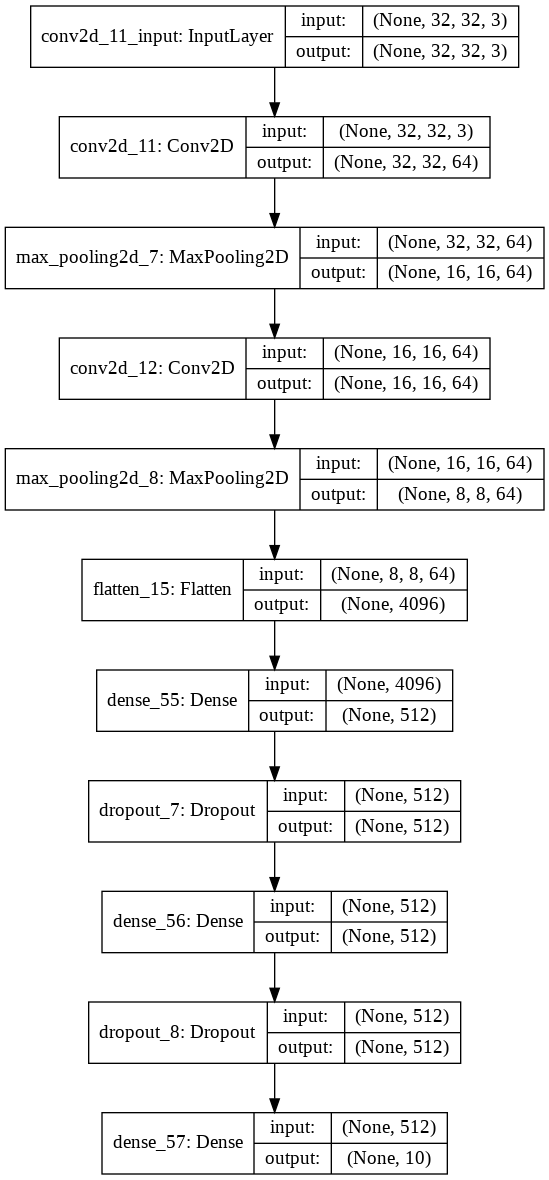

In [29]:
plot_model(cnn2, to_file='cnn2.png', show_shapes=True, show_layer_names=True)

--------------------
## Reporting the Testing accuracies..
-----------------------

### Testing accuracy | MLP

In [30]:
loss,acc=mlp_base.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for MLP at base/given architecture: ",acc*100)

5000/5000 [==============================] - 0s 74us/step
Testing Accuracy for MLP at base/given architecture:  36.000001430511475


### Testing accuracy | CNN-1

In [31]:
loss_c1,acc_c1=cnn1.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for CNN-1: ",acc_c1*100)

5000/5000 [==============================] - 1s 125us/step
Testing Accuracy for CNN-1:  54.79999780654907


### Testing accuracy | CNN-2

In [32]:
loss_c2,acc_c2=cnn2.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for CNN-2: ",acc_c2*100)

5000/5000 [==============================] - 0s 97us/step
Testing Accuracy for CNN-2:  57.30000138282776


------------------------------
## Time Analysis:
--------------------------------

In [33]:
cnn1_t=stop_cnn1-start_cnn1
cnn2_t=stop_cnn2-start_cnn2
print("Time taken by Base MLP:", stop_mlp-start_mlp)
print("Time taken by CNN-1: ",stop_cnn1-start_cnn1)
print("Time taken by CNN-2: ",stop_cnn2-start_cnn2)
pd.concat([pd.DataFrame({"Model":["CNN-1","CNN-2"]}),pd.DataFrame({"Time Taken":[cnn1_t,cnn2_t]})],axis=1)

Time taken by Base MLP: 9.123910870000032
Time taken by CNN-1:  46.87815582999997
Time taken by CNN-2:  13.368020463999983


,Model,Time Taken
0,CNN-1,46.878156
1,CNN-2,13.368020


------------------------
## Plots
-------------------------

MLP Plots for Training and validation | Accuracy and Loss


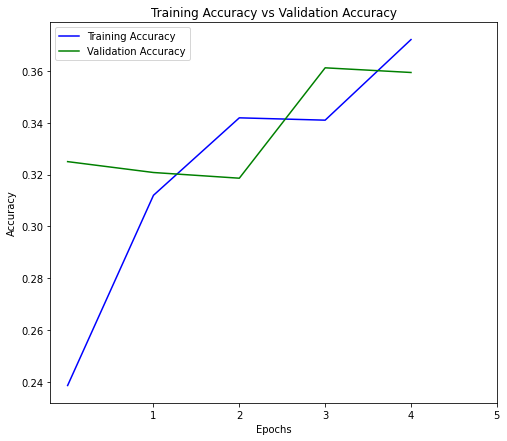

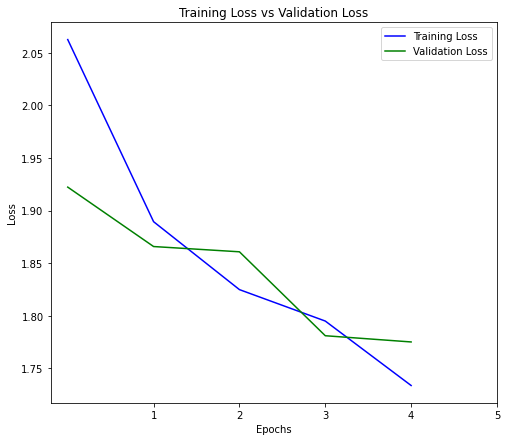

In [34]:
"""
MLP Plot for Training and validation
"""
print("MLP Plots for Training and validation | Accuracy and Loss")
mlp=Plots(mlp_base_h)
mlp.accuracy()
mlp.loss()

______________
### CNN- 1 Plots for Training and validation 
_________________

CNN- 1 Plots for Training and validation | Accuracy and Loss


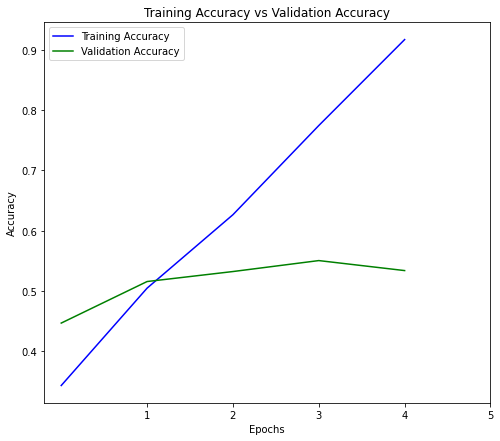

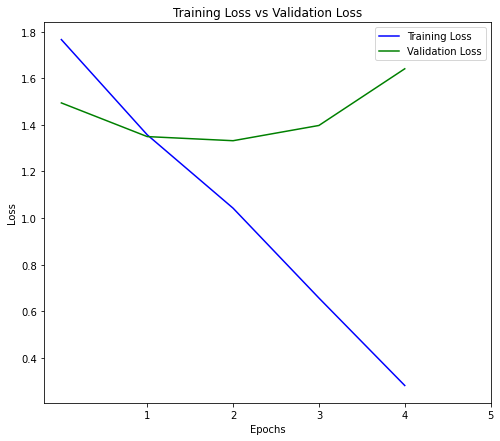

In [35]:

"""
CNN- 1 Plots for Training and validation 
"""
print("CNN- 1 Plots for Training and validation | Accuracy and Loss")
cnn1plot=Plots(cnn1_h)
cnn1plot.accuracy()
cnn1plot.loss()

________________________________
### CNN- 2 Plots for Training and validation 
__________________________________

CNN- 2 Plots for Training and validation | Accuracy and Loss


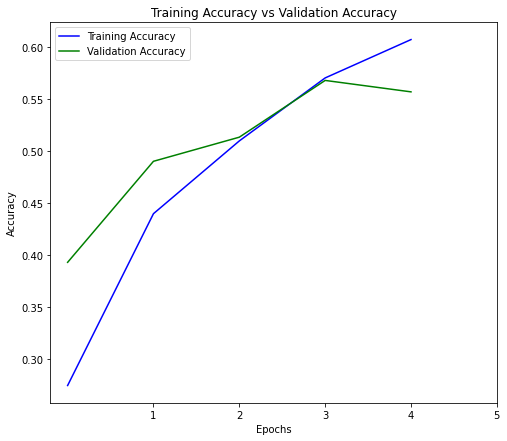

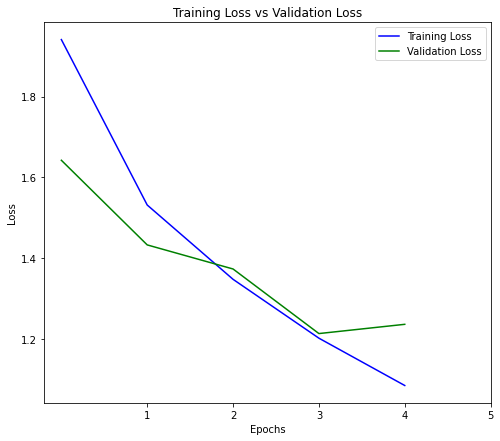

In [36]:
"""
CNN- 1 Plots for Training and validation 
"""
print("CNN- 2 Plots for Training and validation | Accuracy and Loss")

cnn2plot=Plots(cnn2_h)
cnn2plot.accuracy()
cnn2plot.loss()

## MLP PLots for Report for different architectures

In [37]:
names=pd.DataFrame({"Model Name":["MLP_base","MLP 1","MLP 2","MLP 3","MLP 4","MLP 5","MLP 6","MLP 7","MLP 8"]})
desc=pd.DataFrame({"Description":["2 H.L/Dense | 512 neurons","2 H.L/Dense | 1024 neurons","2 H.L/Dense | 2048 neurons"
                  ,"3 H.L/Dense | 512 neurons","3 H.L/Dense | 1024 neurons","3 H.L/Dense | 2048 neurons"
                                       ,"4 H.L/Dense | 512 neurons","4 H.L/Dense | 1024 neurons","4 H.L/Dense | 2048 neurons"]})
MLP_models=pd.concat([names,desc],axis=1)

In [38]:
MLP_models

,Model Name,Description
0,MLP_base,2 H.L/Dense | 512 neurons
1,MLP 1,2 H.L/Dense | 1024 neurons
2,MLP 2,2 H.L/Dense | 2048 neurons
3,MLP 3,3 H.L/Dense | 512 neurons
4,MLP 4,3 H.L/Dense | 1024 neurons
5,MLP 5,3 H.L/Dense | 2048 neurons
6,MLP 6,4 H.L/Dense | 512 neurons
7,MLP 7,4 H.L/Dense | 1024 neurons
8,MLP 8,4 H.L/Dense | 2048 neurons


In [39]:
def mlp_variants(acc_type):
    # mlp plots for different models
    # Training accuracy diff mlp models
    
    plt.figure(figsize=(10,7))
    plt.plot(mlp_base_h.history[acc_type])
    plt.plot(mlp1_h.history[acc_type])
    plt.plot(mlp2_h.history[acc_type])
    plt.plot(mlp3_h.history[acc_type])
    plt.plot(mlp4_h.history[acc_type])
    plt.plot(mlp5_h.history[acc_type])
    plt.plot(mlp6_h.history[acc_type])
    plt.plot(mlp7_h.history[acc_type])
    plt.plot(mlp8_h.history[acc_type])
    plt.xticks([0,1,2,3,4])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["MLP_base","MLP 1","MLP 2","MLP 3","MLP 4","MLP 5","MLP 6","MLP 7","MLP 8"])
    if acc_type=='accuracy':
        plt.title("Training Accuracy for different MLP models")
    else:
        plt.title("Validation Accuracy for different MLP models")
    plt.show()

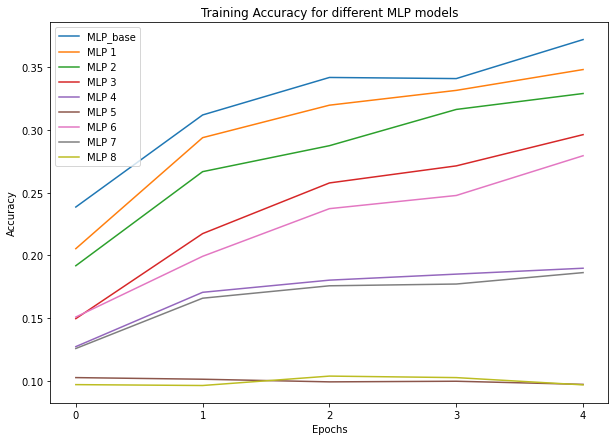

In [40]:
# Training accuracy for different mlp models
mlp_variants('accuracy')

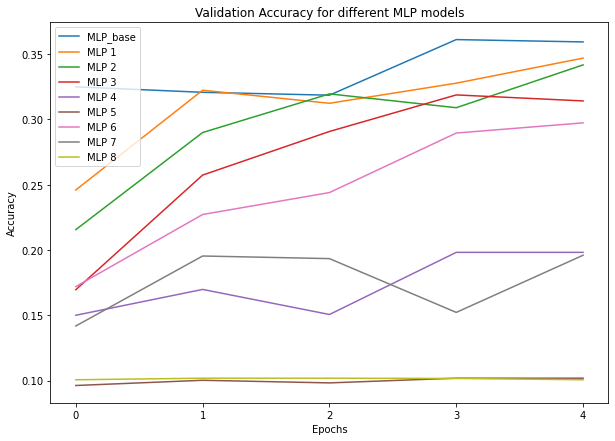

In [41]:
# Validation accuracy for different mlp models
mlp_variants('val_accuracy')

<!-- ## Results analysis using confusion matrix and plots -->

In [42]:
# y_pred=np.argmax(mlp_base.predict(X_test_normalized),axis=1)

# Experimenting with more number of epochs

### MLP

In [43]:

"""
MLP-------------------------------
"""

start_mlp=timeit.default_timer()
print("MLP(512,add_d3=False,add_d4=False) epochs=20" )

"""
Call base MLP: Neurons 512 | Layers 2 Dense
"""
mlp_base=mlp_ob.MLP(512,add_d3=False,add_d4=False) 
mlp_base_h=mlp_base.fit(X_train_normalized, Y_train, batch_size=32, epochs=20, validation_data=(X_val_normalized,Y_val))

stop_mlp=timeit.default_timer()

MLP(512,add_d3=False,add_d4=False) epochs=20
Train on 10000 samples, validate on 5000 samples
Epoch 1/20
10000/10000 [==============================] - 2s 197us/step - loss: 2.0542 - accuracy: 0.2436 - val_loss: 1.9394 - val_accuracy: 0.2880
Epoch 2/20
10000/10000 [==============================] - 2s 184us/step - loss: 1.9006 - accuracy: 0.3097 - val_loss: 1.9061 - val_accuracy: 0.2948
Epoch 3/20
10000/10000 [==============================] - 2s 182us/step - loss: 1.8279 - accuracy: 0.3414 - val_loss: 1.8568 - val_accuracy: 0.3378
Epoch 4/20
10000/10000 [==============================] - 2s 174us/step - loss: 1.7970 - accuracy: 0.3434 - val_loss: 1.8227 - val_accuracy: 0.3440
Epoch 5/20
10000/10000 [==============================] - 2s 173us/step - loss: 1.7591 - accuracy: 0.3600 - val_loss: 1.7659 - val_accuracy: 0.3682
Epoch 6/20
10000/10000 [==============================] - 2s 171us/step - loss: 1.7399 - accuracy: 0.3671 - val_loss: 1.7751 - val_accuracy: 0.3574
Epoch 7/20
10000/1

In [44]:
loss,acc=mlp_base.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for MLP at base/given architecture at 20 epochs: ",acc*100)

5000/5000 [==============================] - 0s 66us/step
Testing Accuracy for MLP at base/given architecture at 20 epochs:  36.820000410079956


In [45]:
print("CNN-1-20 epochs")

# creating an instance of Models class for CNN-1

"""
CNN-1 ---------------------------------------
"""
start_cnn1=timeit.default_timer()

cnn1=cnn1_ob.CNN1(512)
cnn1_h=cnn1.fit(X_train_normalized, Y_train, batch_size=32, epochs=20, validation_data=(X_val_normalized,Y_val))

stop_cnn1=timeit.default_timer()

CNN-1-20 epochs
Train on 10000 samples, validate on 5000 samples
Epoch 1/20
10000/10000 [==============================] - 9s 931us/step - loss: 1.7651 - accuracy: 0.3468 - val_loss: 1.5501 - val_accuracy: 0.4232
Epoch 2/20
10000/10000 [==============================] - 9s 921us/step - loss: 1.3101 - accuracy: 0.5186 - val_loss: 1.3769 - val_accuracy: 0.5032
Epoch 3/20
10000/10000 [==============================] - 9s 921us/step - loss: 0.9562 - accuracy: 0.6622 - val_loss: 1.3490 - val_accuracy: 0.5378
Epoch 4/20
10000/10000 [==============================] - 9s 922us/step - loss: 0.5639 - accuracy: 0.8087 - val_loss: 1.4275 - val_accuracy: 0.5476
Epoch 5/20
10000/10000 [==============================] - 9s 917us/step - loss: 0.2093 - accuracy: 0.9425 - val_loss: 1.6805 - val_accuracy: 0.5500
Epoch 6/20
10000/10000 [==============================] - 9s 922us/step - loss: 0.0546 - accuracy: 0.9894 - val_loss: 1.7562 - val_accuracy: 0.5542
Epoch 7/20
10000/10000 [=======================

In [46]:
loss_c1,acc_c1=cnn1.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for CNN-1 at 20 epochs: ",acc_c1*100)

5000/5000 [==============================] - 1s 121us/step
Testing Accuracy for CNN-1 at 20 epochs:  57.840001583099365


In [47]:
# creating an instance of Models for CNN-2

print("CNN-2-20 epochs")

cnn2_ob=Models(X_train_normalized)

"""
CNN-2
"""
start_cnn2=timeit.default_timer()

cnn2=cnn2_ob.CNN2(512)
cnn2_h=cnn2.fit(X_train_normalized,Y_train,batch_size=32,epochs=20,validation_data=(X_val_normalized,Y_val))

stop_cnn2=timeit.default_timer()

CNN-2-20 epochs
Train on 10000 samples, validate on 5000 samples
Epoch 1/20
10000/10000 [==============================] - 3s 266us/step - loss: 1.9536 - accuracy: 0.2719 - val_loss: 1.6523 - val_accuracy: 0.3946
Epoch 2/20
10000/10000 [==============================] - 2s 244us/step - loss: 1.5679 - accuracy: 0.4211 - val_loss: 1.4678 - val_accuracy: 0.4666
Epoch 3/20
10000/10000 [==============================] - 2s 245us/step - loss: 1.3936 - accuracy: 0.4906 - val_loss: 1.3313 - val_accuracy: 0.5172
Epoch 4/20
10000/10000 [==============================] - 2s 247us/step - loss: 1.2532 - accuracy: 0.5444 - val_loss: 1.3657 - val_accuracy: 0.5074
Epoch 5/20
10000/10000 [==============================] - 2s 248us/step - loss: 1.1383 - accuracy: 0.5860 - val_loss: 1.2334 - val_accuracy: 0.5502
Epoch 6/20
10000/10000 [==============================] - 2s 246us/step - loss: 1.0228 - accuracy: 0.6384 - val_loss: 1.2205 - val_accuracy: 0.5636
Epoch 7/20
10000/10000 [=======================

In [48]:
loss_c2,acc_c2=cnn2.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for CNN-2-20 epochs: ",acc_c2*100)

5000/5000 [==============================] - 0s 89us/step
Testing Accuracy for CNN-2-20 epochs:  60.659998655319214


# Experimenting by changing the architecture

In [65]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(10, activation='softmax'))
# compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

"""
Model2 
"""
# model=Sequential()
        
# model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same',activation='relu',
#                          input_shape=X_train_normalized.shape[1:]))                    # Conv layer with 64 filters, filter shape=(3,3,3), input shape => (B.S,32,32,3) 
# model.add(MaxPooling2D(pool_size=(2,2)))                                            # Max pooling with a filter of (2,2) for capturing important features.

# model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu'))  # Conv layer with 64 filters, filter shape=(3,3,64), input shape => (B.S,32,32,3)         
# model.add(MaxPooling2D(pool_size=(2,2)))                   # Max pooling with a filter of (2,2) for capturing important features.
        
# model.add(Flatten())                                       # Flattening before the dense layer
# model.add(Dense(256,activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))        # Fully connected layer with 512 neurons and sigmoid as activation.
# model.add(Dropout(0.5))                                    # Dropout of 0.2 to prevent overfitting.

# model.add(Dense(256,activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.4))                                    # Dropout of 0.2 to prevent overfitting after 2nd dense layer.
        
# model.add(Dense(10, activation='softmax'))                 # Dense layer with 10 neurons as output layer.
        
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # Initializes the optimizer and loss function for training.
        

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

'\nModel2 \n'

In [67]:
model_h=model.fit(X_train_normalized,Y_train,batch_size=32,epochs=10,validation_data=(X_val_normalized,Y_val))

Train on 10000 samples, validate on 5000 samples
Epoch 1/10
10000/10000 [==============================] - 5s 497us/step - loss: 2.4886 - accuracy: 0.2457 - val_loss: 1.8600 - val_accuracy: 0.3054
Epoch 2/10
10000/10000 [==============================] - 4s 409us/step - loss: 1.7811 - accuracy: 0.3521 - val_loss: 1.6791 - val_accuracy: 0.3858
Epoch 3/10
10000/10000 [==============================] - 4s 410us/step - loss: 1.6494 - accuracy: 0.4067 - val_loss: 1.5429 - val_accuracy: 0.4512
Epoch 4/10
10000/10000 [==============================] - 4s 409us/step - loss: 1.5361 - accuracy: 0.4501 - val_loss: 1.4859 - val_accuracy: 0.4772
Epoch 5/10
10000/10000 [==============================] - 4s 413us/step - loss: 1.4516 - accuracy: 0.4836 - val_loss: 1.4434 - val_accuracy: 0.4936
Epoch 6/10
10000/10000 [==============================] - 4s 410us/step - loss: 1.3810 - accuracy: 0.5162 - val_loss: 1.4055 - val_accuracy: 0.5206
Epoch 7/10
10000/10000 [==============================] - 4s 40

In [68]:
_,acc=model.evaluate(X_test_normalized,Y_test)

5000/5000 [==============================] - 1s 163us/step


In [69]:
print(acc*100)

57.1399986743927
